In [84]:
import warnings

import numpy as np
import pandas as pd

# Импорт необходимых модулей
from scripts.calibrate_models import calibrate_fx_model, calibrate_models
from scripts.compare_models import compare_models, create_model
from scripts.simulate_model import simulate_model
from src.visualization.plots import plot_fx_analysis, plot_historical_data, plot_simulation
from src.visualization.stats import print_best_params, print_statistics

warnings.filterwarnings("ignore")

# SORF

SOFR отражает стоимость overnight-кредитования под залог казначейских ценных бумаг

In [85]:
raw_sofr_df = pd.read_excel("data/us-sofr.xlsx")
raw_sofr_df = raw_sofr_df.rename(columns={"Effective Date": "Date", "Rate (%)": "Rate"})[
    ["Date", "Rate"]
]
raw_sofr_df["Date"] = pd.to_datetime(raw_sofr_df["Date"])
raw_sofr_df["Rate"] = raw_sofr_df["Rate"] / 100

Статистика и график исторических данных SOFR, показывающий динамику ставки за анализируемый период.

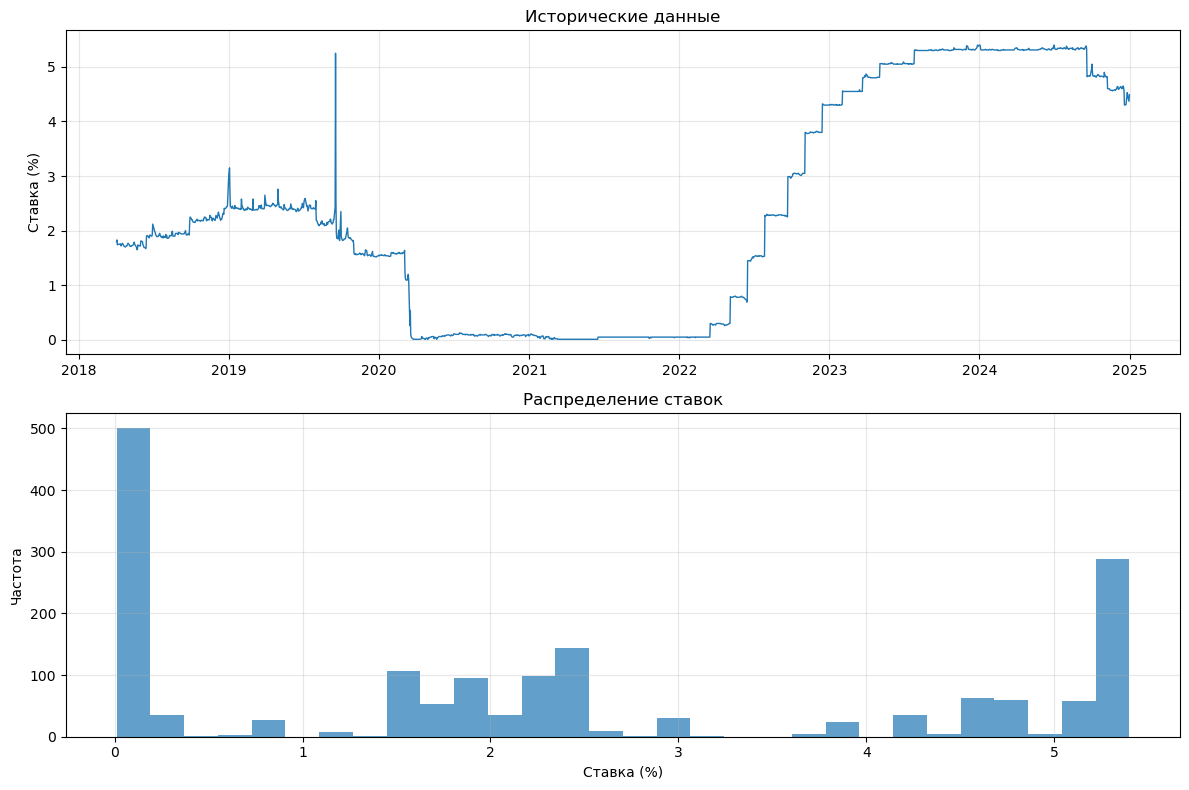

In [86]:
plot_historical_data(raw_sofr_df)

Определение временных параметров анализа
В качестве исторических данных для калибровки параметров модели выбран период с июня 2018 года.

Горизонт прогнозирования, релевантный для большинства финансовых инструментов, равен одному году. 

In [87]:
calc_date = pd.Timestamp("2021-12-10")
start_date = raw_sofr_df["Date"].min()
end_date = calc_date + pd.Timedelta(days=365)

In [88]:
# Фильтруем данные до нашей расчетной даты
sofr_hist = raw_sofr_df[
    (raw_sofr_df["Date"] >= start_date) & (raw_sofr_df["Date"] <= calc_date)
].copy()
sofr_df = sofr_hist.dropna()

# Берем ставку на расчетную дату
sofr_initial = sofr_hist[sofr_hist["Date"] == calc_date]["Rate"].values[0]
print(f"Начальная ставка SOFR на 10.12.2021: {sofr_initial * 100:.4f}%")

Начальная ставка SOFR на 10.12.2021: 0.0500%


СТАТИСТИКА ДАННЫХ (СТАВКА):
• Объем данных: 925 наблюдений
• Минимальный ставка: 0.0100 %
• Максимальный ставка: 5.2500 %
• Средний ставка: 1.1053 %
• Медиана: 1.5400 %
• Стандартное отклонение: 1.0318 %
• Коэффициент вариации: 0.9335

• 25-й перцентиль: 0.0500 %
• 75-й перцентиль: 2.1200 %
• IQR: 2.0700 %

Анализ изменений ставок:
• Среднее дневное изменение: 0.0019%
• Волатильность изменений: 0.1437%
• Макс. рост за день: 2.7000%
• Макс. падение за день: -2.8200%


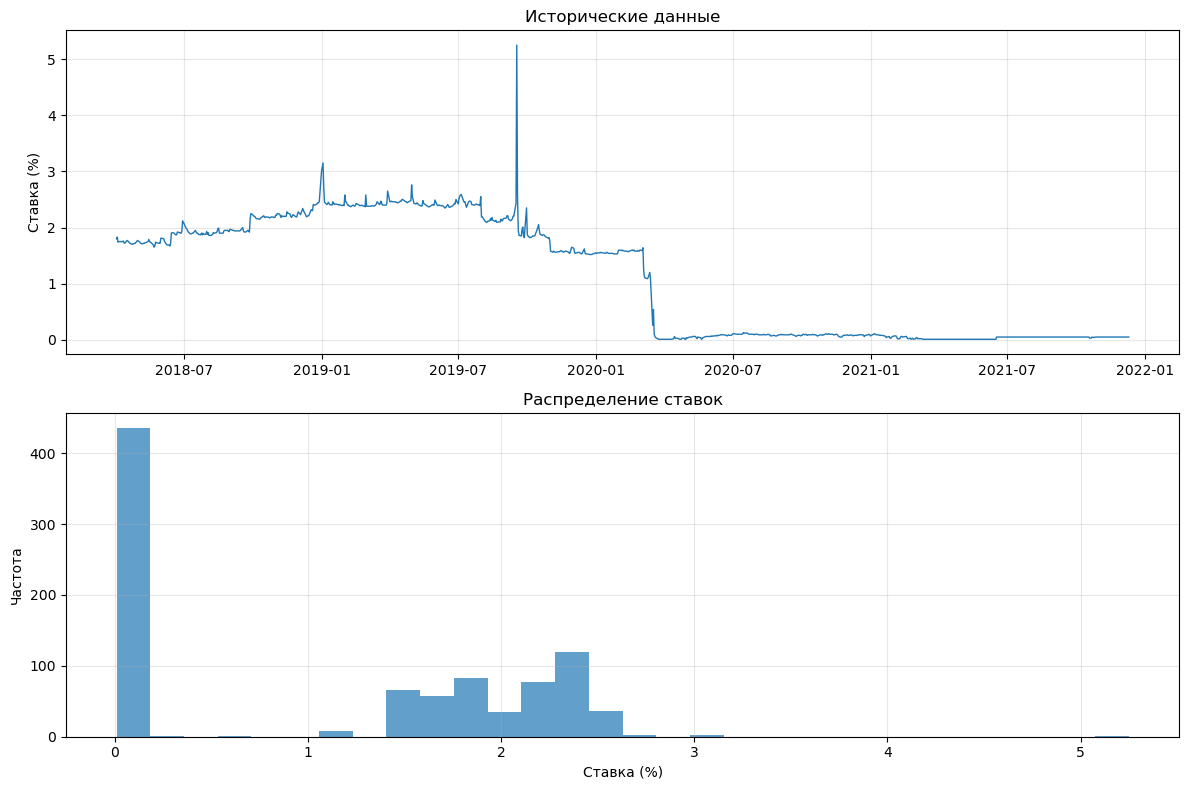

In [89]:
print_statistics(sofr_df["Rate"])
plot_historical_data(sofr_df)

Начальная ставка SOFR на 10.12.2021: 0.05% - чрезвычайно низкое значение, характерное для пост-пандемического периода.

## T-bills

T-bills - государственные облигации США. Кривая доходности по T-bills используется для расчета форвардной ставки.


In [122]:
us_g_curve_df = pd.read_excel("data/t-bills.xlsx", sheet_name=1)
us_g_curve_df = us_g_curve_df.rename(columns={"observation_date": "Date", "DGS3MO": "Rate"})[
    ["Date", "Rate"]
]
us_g_curve_df["Date"] = pd.to_datetime(us_g_curve_df["Date"])
us_g_curve_df["Rate"] = us_g_curve_df["Rate"] / 100

# Фильтруем данные до нашей расчетной даты
us_g_curve_df = us_g_curve_df[
    (us_g_curve_df["Date"] >= start_date) & (us_g_curve_df["Date"] <= calc_date)
].copy()
us_g_curve_df = us_g_curve_df.dropna()

СТАТИСТИКА ДАННЫХ (СТАВКА):
• Объем данных: 752 наблюдений
• Минимальный ставка: 0.0000 %
• Максимальный ставка: 2.4900 %
• Средний ставка: 0.8792 %
• Медиана: 0.1200 %
• Стандартное отклонение: 0.9930 %
• Коэффициент вариации: 1.1295

• 25-й перцентиль: 0.0500 %
• 75-й перцентиль: 1.9500 %
• IQR: 1.9000 %

Анализ изменений ставок:
• Среднее дневное изменение: -0.0031%
• Волатильность изменений: 0.0248%
• Макс. рост за день: 0.1100%
• Макс. падение за день: -0.2300%


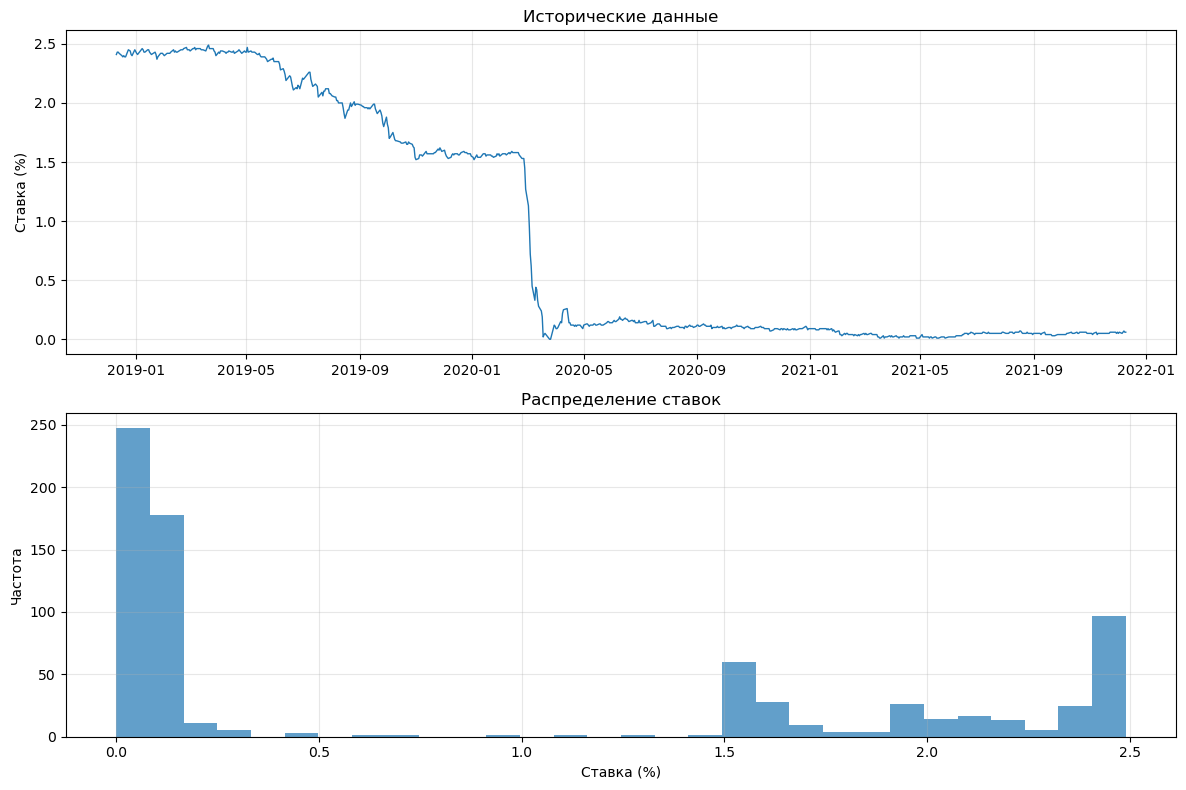

In [123]:
print_statistics(us_g_curve_df["Rate"])
plot_historical_data(us_g_curve_df)

Ключевые наблюдения по сравнению SOFR и T-bills:

- Схожий диапазон но разное распределение

- Более низкая волатильность T-bills, т.к. практически безрисковый актив

- Значительно меньшие выбросов - плавная динамика

Различия отражают разные природы инструментов. SOFR более чувствителен к краткосрочным ликвидностным шокам. T-bills отражает ожидания денежной политики


Калибровка моделей...
1. Модель с постоянной theta...
   α=0.0010, σ=0.1764, θ=0.0003
Условие Феллера: НЕ ВЫПОЛНЕНО
2. Модель с theta на основе G-кривой...
   На основе G-кривой, метод: spline
   Количество точек: 752

Симуляция constant модели...


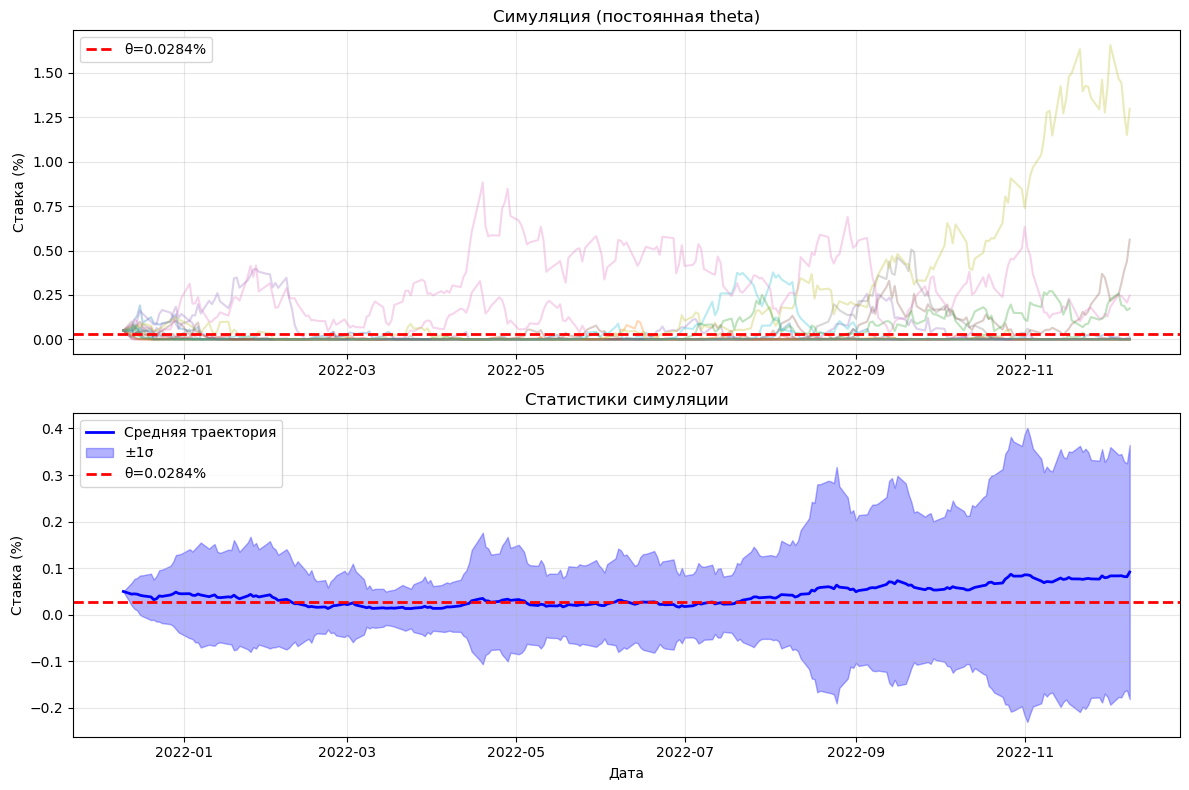


Симуляция g_curve модели...


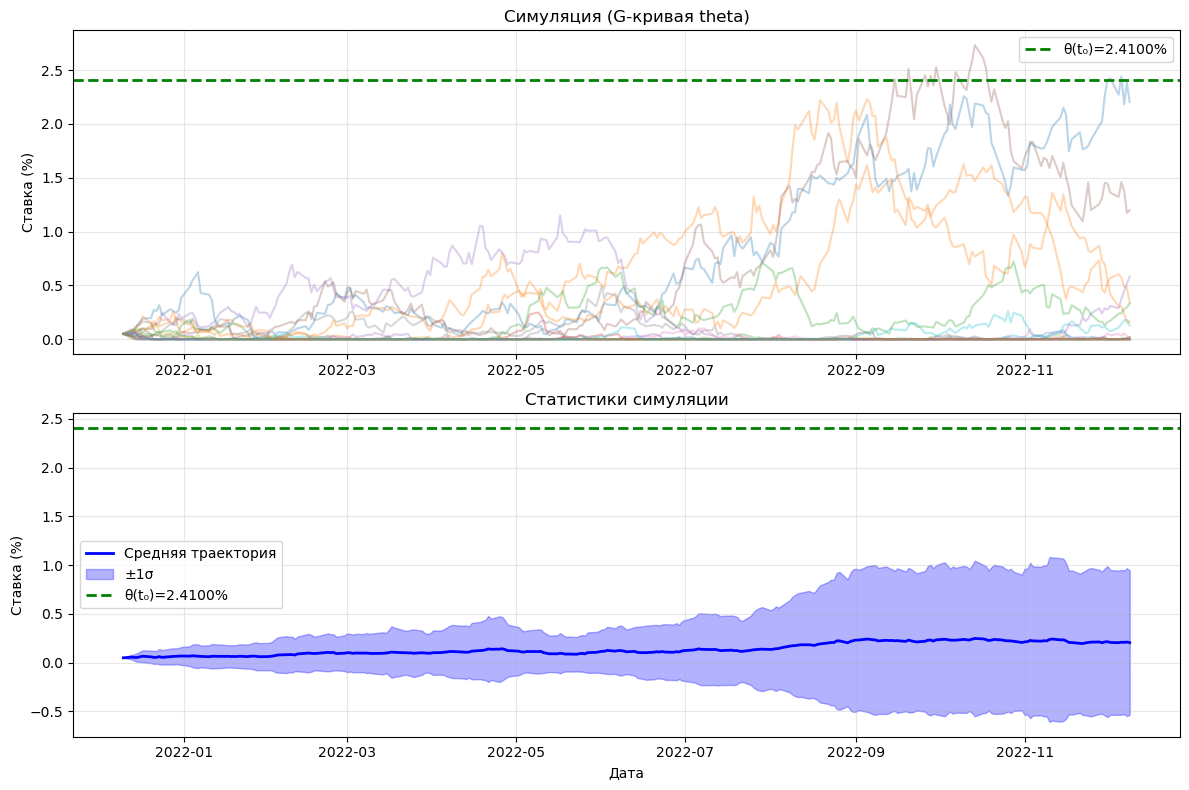

In [124]:
# Калибровка
models = calibrate_models(sofr_df["Rate"].values, mode="sofr", g_curve_data=us_g_curve_df)

# Симуляция для каждой модели
for model_type in models:
    print(f"\nСимуляция {model_type} модели...")
    model = create_model(models[model_type], model_type)
    dates, trajectories = simulate_model(
        model=model,
        initial_value=sofr_initial,
        start_date=calc_date,
        end_date=end_date,
        n_paths=50,
        model_type="rate",
    )
    plot_simulation(dates, trajectories, model_type, models[model_type])


СРАВНЕНИЕ МОДЕЛЕЙ
Постоянная θ: LogL = 5494.2631
  θ = 0.0003 (0.03%)

Построение графиков сравнения...


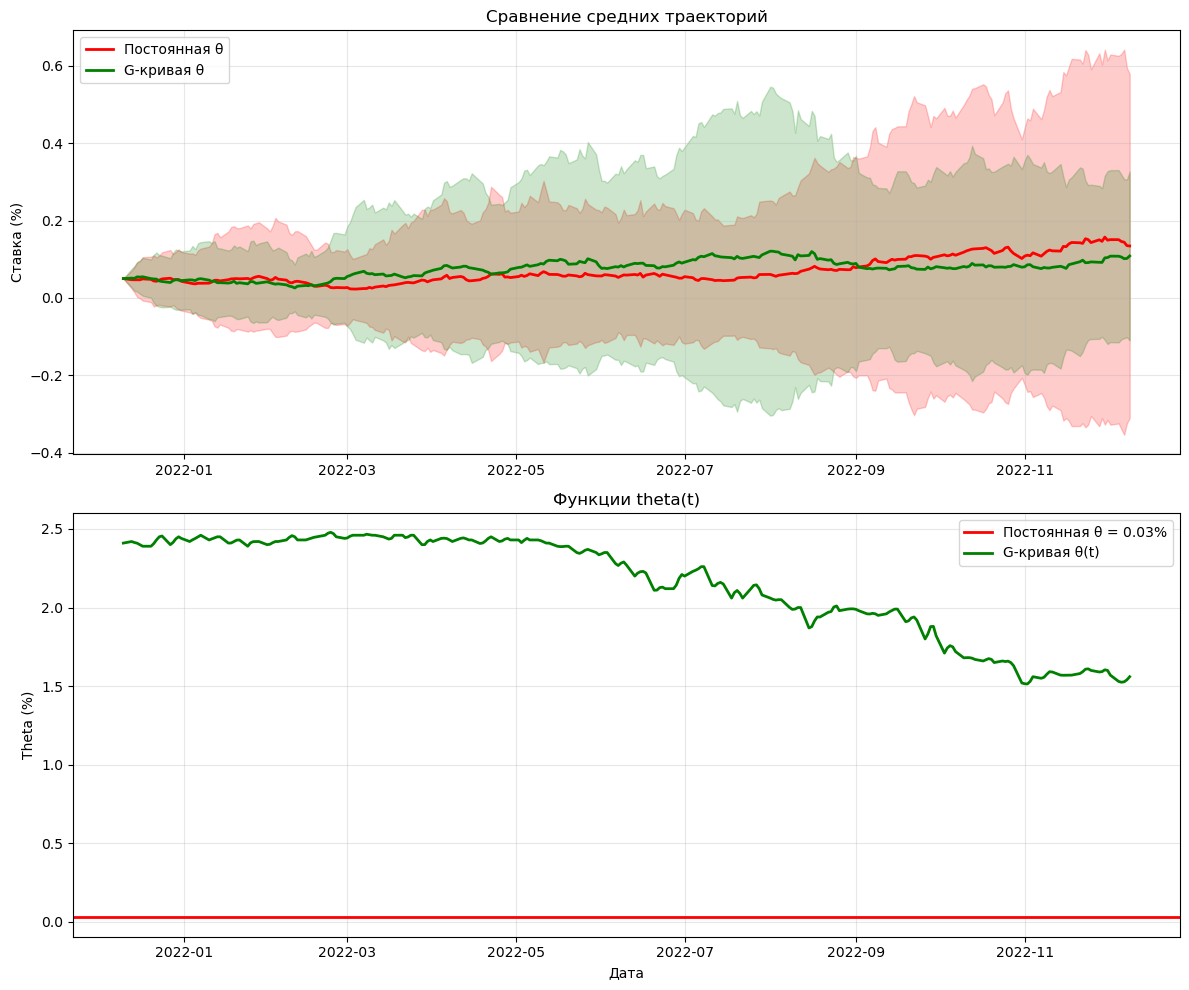

'g_curve'

In [125]:
compare_models(models, sofr_initial, calc_date, end_date)

На представленном графике видно, что при очень низком уровне постоянной θ (0.03%) все три метода калибровки дают схожие результаты. Однако даже в этой ситуации калибровка на основе G-кривой предпочтительнее, особенно метод сплайн-интерполяции.
Постоянная θ = 0.03% является искусственно заниженной и не отражает реальной динамики рынка. Такой уровень соответствует периоду экстремально низких ставок, но не может адекватно описывать их будущие изменения. В отличие от этого, G-кривая со сплайн-интерполяцией обеспечивает плавную адаптацию к изменяющимся рыночным условиям, что важно при выходе из сверхнизких процентных ставок.
Кусочно-линейная аппроксимация также сохраняет преимущества адаптивности, но дает менее гладкие переходы


In [127]:
print_best_params(models, "g_curve")


Параметры лучшей модели (g_curve):
• Alpha (α): 0.0010
• Sigma (σ): 0.1764
• Theta(t): на основе G-кривой
• Диапазон G-кривой: 0.00-3.00 лет
• Ставки G-кривой: 0.00%-2.49%
• Метод интерполяции: spline


In [128]:
models["g_curve"]

{'alpha': 0.001,
 'sigma': 0.17637172872443319,
 'theta_function': <function src.calibration.calibrating.calibrate_theta_from_g_curve.<locals>.theta_function(t)>,
 'logl': 5494.263059728425,
 'method': 'spline',
 'times': 245     0.000000
 246     0.002740
 247     0.005479
 248     0.008219
 249     0.016438
           ...   
 1024    2.989041
 1025    2.991781
 1026    2.994521
 1027    2.997260
 1028    3.000000
 Name: Date, Length: 752, dtype: float64,
 'rates': array([0.0241, 0.0243, 0.0243, 0.0242, 0.024 , 0.0239, 0.024 , 0.0239,
        0.0239, 0.0245, 0.0244, 0.0241, 0.024 , 0.0245, 0.0242, 0.0241,
        0.0242, 0.0245, 0.0246, 0.0245, 0.0243, 0.0243, 0.0245, 0.0245,
        0.0243, 0.0242, 0.0241, 0.0243, 0.0241, 0.0237, 0.0239, 0.0242,
        0.0242, 0.0242, 0.0241, 0.024 , 0.0242, 0.0242, 0.0242, 0.0242,
        0.0243, 0.0245, 0.0243, 0.0244, 0.0243, 0.0243, 0.0245, 0.0245,
        0.0245, 0.0246, 0.0247, 0.0245, 0.0245, 0.0245, 0.0244, 0.0246,
        0.0246, 0.0247, 0.

In [133]:
us_best_params = {
    "alpha": models["g_curve"]["alpha"],
    "sigma": models["g_curve"]["sigma"], 
    "theta_func": models["g_curve"]["theta_function"]
}

# RUONIA

In [164]:
raw_ruonia_df = pd.read_excel("data/ru-ruonia.xlsx")
raw_ruonia_df = raw_ruonia_df.rename(columns={"DT": "Date", "ruo": "Rate"})[["Date", "Rate"]]
raw_ruonia_df["Date"] = pd.to_datetime(raw_ruonia_df["Date"])
raw_ruonia_df["Rate"] = raw_ruonia_df["Rate"] / 100

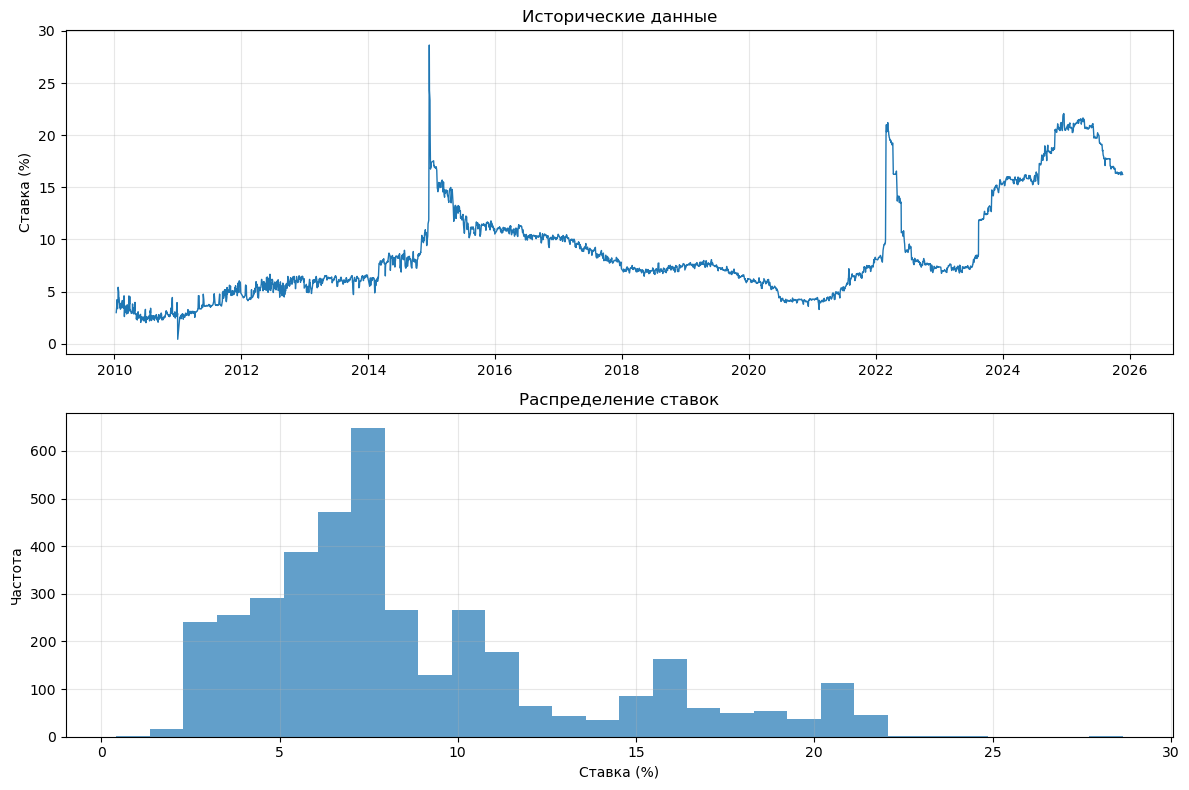

In [165]:
plot_historical_data(raw_ruonia_df)

In [166]:
calc_date = pd.Timestamp("2021-12-10")
start_date = calc_date - pd.Timedelta(days=365 * 3)
end_date = calc_date + pd.Timedelta(days=365)

In [167]:
# Фильтруем данные до нашей расчетной даты
ruonia_hist = raw_ruonia_df[
    (raw_ruonia_df["Date"] >= start_date) & (raw_ruonia_df["Date"] <= calc_date)
].copy()
ruonia_df = ruonia_hist.dropna()

# Берем ставку на расчетную дату
ruonia_initial = ruonia_df[ruonia_df["Date"] == calc_date]["Rate"].values[0]
print(f"Начальная ставка SOFR на 10.12.2021: {ruonia_initial * 100:.4f}%")

Начальная ставка SOFR на 10.12.2021: 7.4500%


СТАТИСТИКА ДАННЫХ (СТАВКА):
• Объем данных: 733 наблюдений
• Минимальный ставка: 3.2800 %
• Максимальный ставка: 8.0600 %
• Средний ставка: 5.8837 %
• Медиана: 6.0200 %
• Стандартное отклонение: 1.3199 %
• Коэффициент вариации: 0.2243

• 25-й перцентиль: 4.3500 %
• 75-й перцентиль: 7.1400 %
• IQR: 2.7900 %

Анализ изменений ставок:
• Среднее дневное изменение: -0.0000%
• Волатильность изменений: 0.1376%
• Макс. рост за день: 0.5900%
• Макс. падение за день: -0.8800%


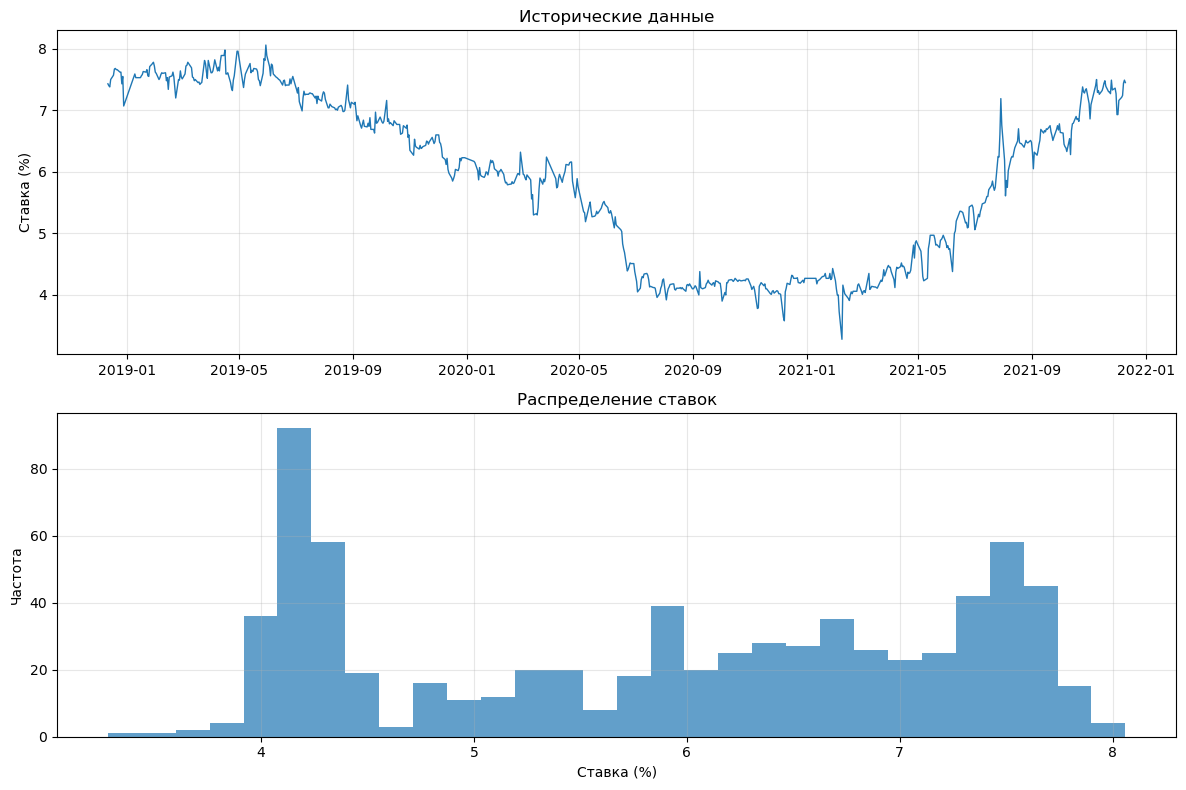

In [168]:
print_statistics(ruonia_df["Rate"])
plot_historical_data(ruonia_df)

In [139]:
ru_g_curve_df = pd.read_excel("data/zcyc.xlsx", decimal=",")
ru_g_curve_df = ru_g_curve_df.rename(columns={"tradedate": "Date", "period_0.25": "Rate"})[
    ["Date", "Rate"]
]
ru_g_curve_df["Date"] = pd.to_datetime(ru_g_curve_df["Date"], format="%d.%m.%Y")
ru_g_curve_df["Rate"] = ru_g_curve_df["Rate"].astype(float) / 100

# Фильтруем данные до нашей расчетной даты
ru_g_curve_df = ru_g_curve_df[
    (ru_g_curve_df["Date"] >= start_date) & (ru_g_curve_df["Date"] <= calc_date)
].copy()
ru_g_curve_df = ru_g_curve_df.dropna()

СТАТИСТИКА ДАННЫХ (СТАВКА):
• Объем данных: 758 наблюдений
• Минимальный ставка: 3.0000 %
• Максимальный ставка: 8.4700 %
• Средний ставка: 5.7635 %
• Медиана: 5.7750 %
• Стандартное отклонение: 1.2849 %
• Коэффициент вариации: 0.2229

• 25-й перцентиль: 4.5625 %
• 75-й перцентиль: 6.9700 %
• IQR: 2.4075 %

Анализ изменений ставок:
• Среднее дневное изменение: 0.0006%
• Волатильность изменений: 0.2098%
• Макс. рост за день: 1.0300%
• Макс. падение за день: -1.1100%


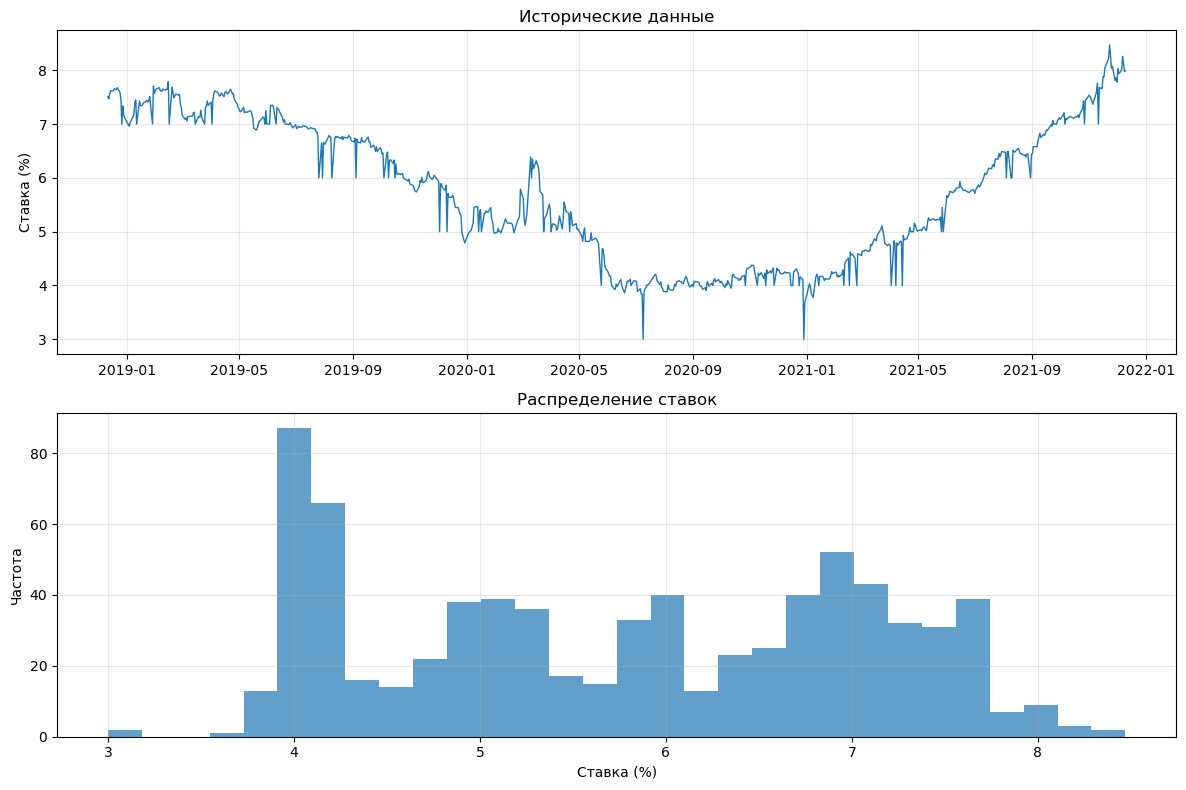

In [140]:
print_statistics(ru_g_curve_df["Rate"])
plot_historical_data(ru_g_curve_df)


Калибровка моделей...
1. Модель с постоянной theta...
   α=1.4481, σ=0.0919, θ=0.0588
Условие Феллера: ВЫПОЛНЕНО
2. Модель с theta на основе G-кривой...
   На основе G-кривой, метод: spline
   Количество точек: 758

Симуляция constant модели...


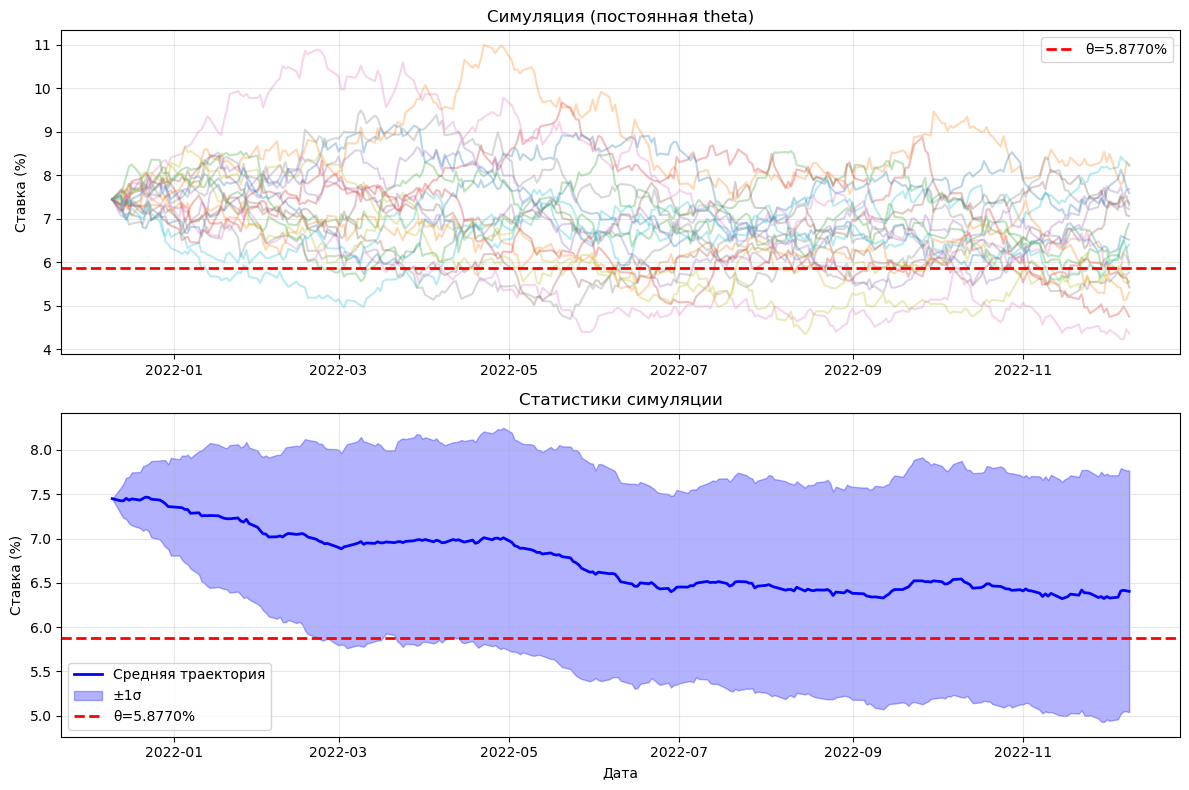


Симуляция g_curve модели...


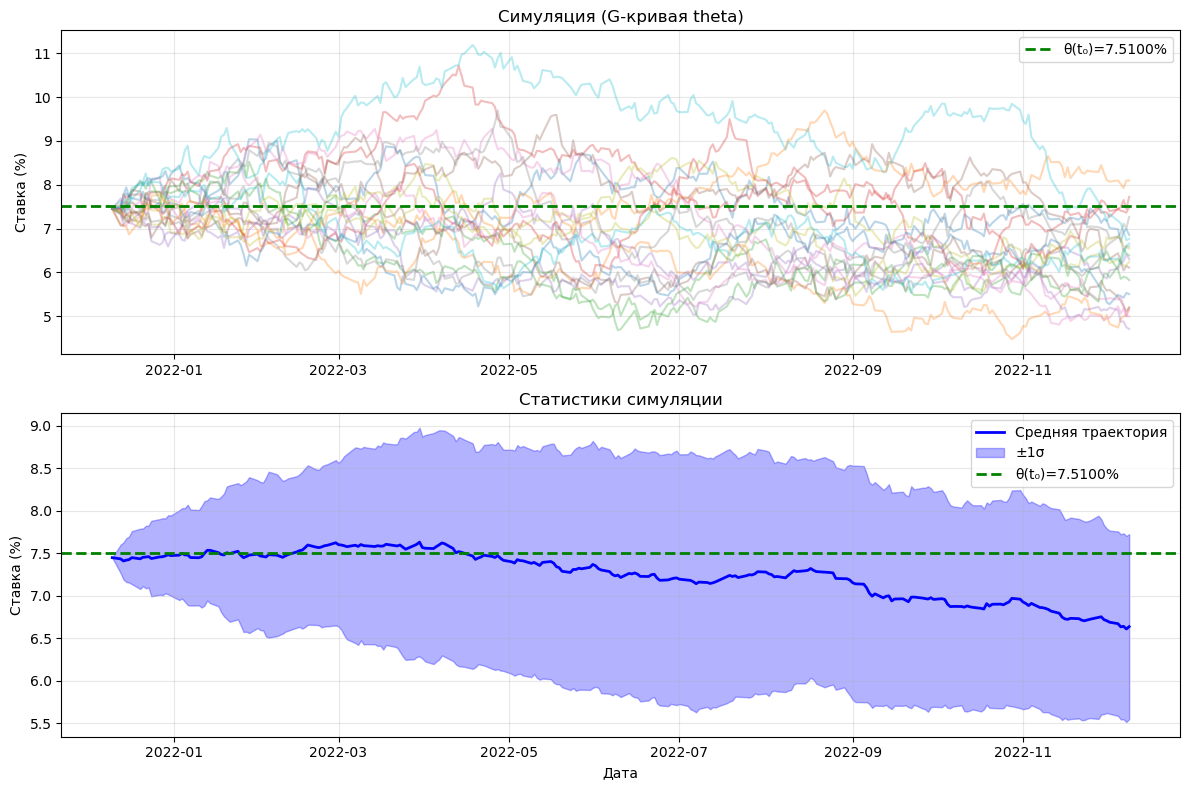

In [169]:
# Калибровка
models = calibrate_models(ruonia_df["Rate"].values, mode="rub", g_curve_data=ru_g_curve_df)

# Симуляция для каждой модели
for model_type in models:
    print(f"\nСимуляция {model_type} модели...")
    model = create_model(models[model_type], model_type)
    dates, trajectories = simulate_model(
        model=model,
        initial_value=ruonia_initial,
        start_date=calc_date,
        end_date=end_date,
        n_paths=50,
        model_type="rate",
    )
    simulate_model(model, ruonia_initial, calc_date, end_date)
    plot_simulation(dates, trajectories, model_type, models[model_type])


СРАВНЕНИЕ МОДЕЛЕЙ
Постоянная θ: LogL = 3779.1301
  θ = 0.0588 (5.88%)

Построение графиков сравнения...


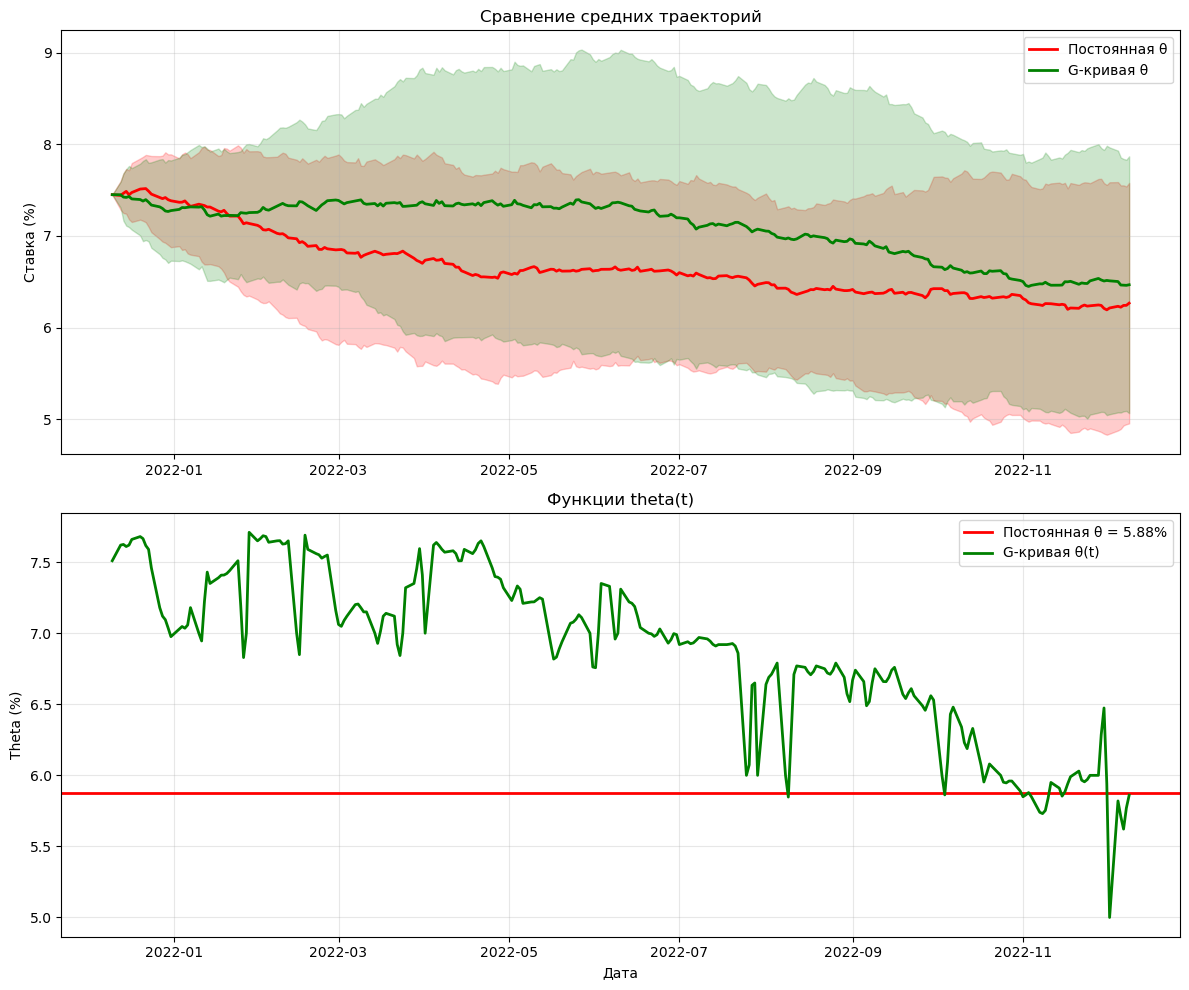

'g_curve'

In [170]:
compare_models(models, ruonia_initial, calc_date, end_date)

На основе анализа графиков рекомендуется использовать калибровку θ на основе G-кривой со сплайн-интерполяцией. Данный метод демонстрирует лучшую адаптивность к изменяющимся рыночным условиям по сравнению с постоянной θ, которая фиксирует ставку на уровне 5.88% и не отражает текущие рыночные ожидания. При этом сплайн-интерполяция обеспечивает более плавную и реалистичную динамику по сравнению с кусочно-линейным методом. Подход с G-кривой позволяет модели учитывать временную структуру процентных ставок и лучше соответствовать актуальной рыночной информации, что особенно важно для задач оценки производных инструментов и краткосрочного прогнозирования.

In [143]:
print_best_params(models, "g_curve")


Параметры лучшей модели (g_curve):
• Alpha (α): 1.4481
• Sigma (σ): 0.0919
• Theta(t): на основе G-кривой
• Диапазон G-кривой: 0.00-3.00 лет
• Ставки G-кривой: 3.00%-8.47%
• Метод интерполяции: spline


In [145]:
ru_best_params = {
    "alpha": models["g_curve"]["alpha"],
    "sigma": models["g_curve"]["sigma"],
    "theta_func": models["g_curve"]["theta_function"]
}

# RUB/USD

In [146]:
fx_df = pd.read_excel("data/rub_usd.xlsx")
fx_df = fx_df.rename(columns={"data": "Date", "curs": "Rate"})
fx_df["Date"] = pd.to_datetime(fx_df["Date"])
fx_df = fx_df.sort_values("Date")

# Оставляем период до расчётной даты
calculation_date = pd.Timestamp("2021-12-10")
fx_hist = fx_df[(fx_df["Date"] >= start_date) & (fx_df["Date"] <= calculation_date)].copy()
fx_hist = fx_hist.dropna(subset=["Rate"])

# Берём начальный курс S0 на дату 10.12.2021
fx_initial = fx_hist[fx_hist["Date"] == calculation_date]["Rate"].values[0]
print(f"Начальный курс на {calculation_date.date()}: {fx_initial:.4f} RUB за 1 USD")

Начальный курс на 2021-12-10: 73.5998 RUB за 1 USD


In [147]:
# Расчет лог-доходностей
fx_hist["LogRate"] = np.log(fx_hist["Rate"])
fx_hist["LogReturn"] = fx_hist["LogRate"].diff()
log_returns = fx_hist["LogReturn"].dropna()

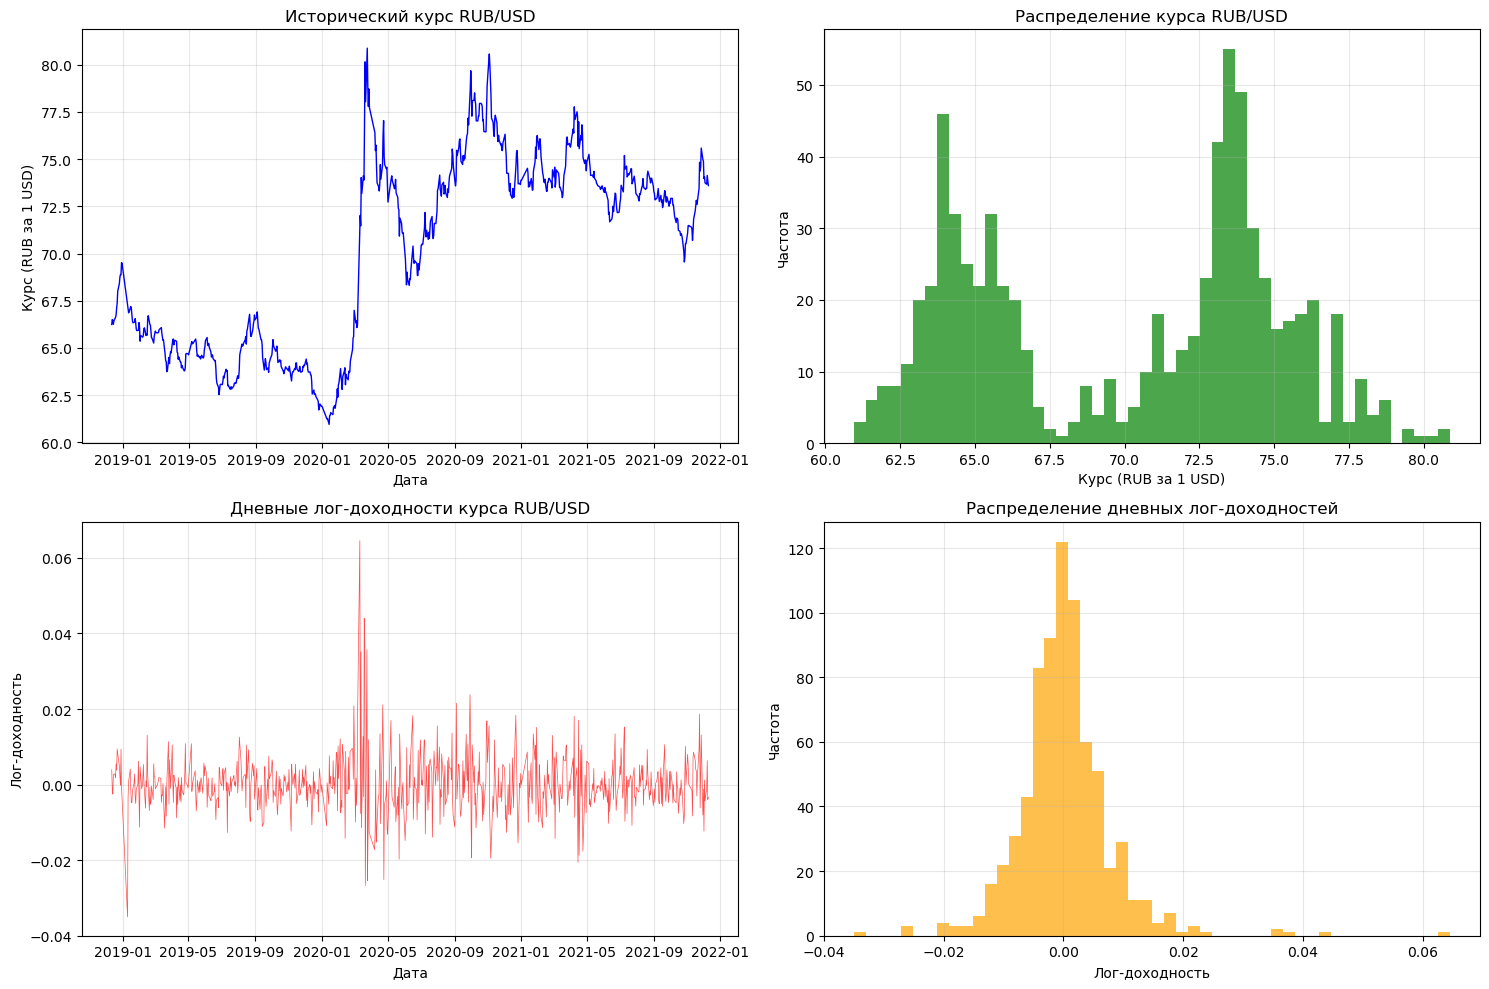

In [148]:
plot_fx_analysis(fx_hist, log_returns)

In [149]:
fx_params = calibrate_fx_model(log_returns)
fx_model = create_model(fx_params, "fx")
dates_fx_simple, trajectories_fx_simple = simulate_model(
    model=fx_model,
    initial_value=fx_initial,
    start_date=calc_date,
    end_date=end_date,
    n_paths=50,
    model_type="fx",
    mu_annual=fx_params["mu_annual"],
)



Калибровка FX модели...
   μ_дневной=0.000143, σ_дневной=0.007697
   μ_годовой=0.036016, σ_годовой=0.122183


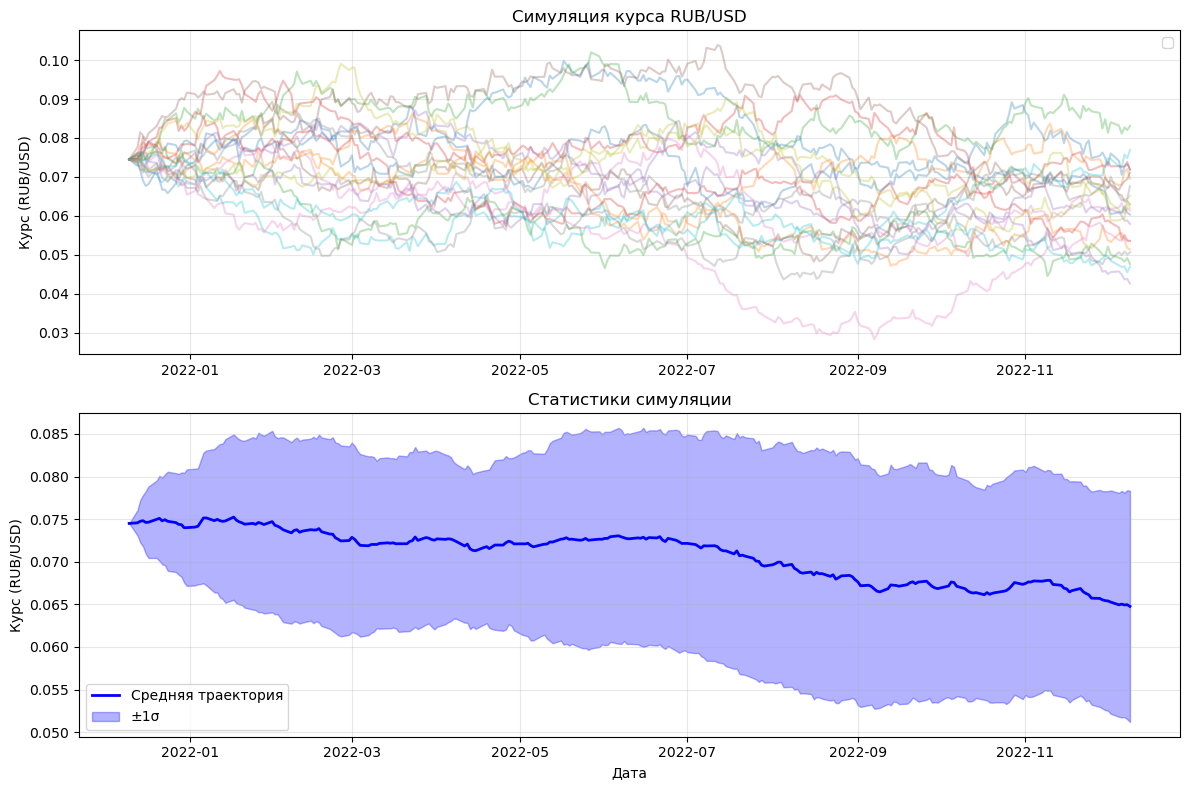

In [150]:
plot_simulation(
    dates=dates,
    trajectories=trajectories,
    model_type="fx",
    title="Симуляция курса RUB/USD",
    asset_type="fx",
)

In [153]:
logfx_best_params = {
    "sigma": 0.007697
}

#### **Оценка корреляций между факторами**

In [ ]:
from src.utils import get_cir_residuals
from src.utils import get_logfx_residuals

In [230]:
def get_theta_arr(
    params: dict,
    start_date: str,
    end_date: str,
    dt: float
):
    start_ts = pd.Timestamp(start_date)
    end_ts = pd.Timestamp(end_date)
    timestamps = pd.date_range(start_ts, end_ts, freq="B")

    theta_func = params["theta_func"]

    theta_arr = [
        theta_func((t - start_ts).days * dt) for t in timestamps
    ]

    return np.array(theta_arr)

In [233]:
size = min(
    sofr_df.shape[0], 
    ruonia_df.shape[0],
    us_g_curve_df.shape[0],
    ru_g_curve_df.shape[0]
)
dt = 1 / 252

theta_arr_ru = get_theta_arr(
    ru_best_params, "2018-12-11", "2021-12-10", dt=dt
)
theta_arr_ru = theta_arr_ru[-size:]


theta_arr_us = get_theta_arr(
    us_best_params, "2018-12-11", "2021-12-10", dt=dt
)
theta_arr_us = theta_arr_us[-size:]

In [238]:
residuals_ru = get_cir_residuals(
    data=ruonia_df.Rate.values[-size:],
    theta=theta_arr_ru,
    alpha=ru_best_params["alpha"],
    dt=1 / 252
)

residuals_us = get_cir_residuals(
    data=sofr_df.Rate.values[-size:],
    theta=theta_arr_us,
    alpha=us_best_params["alpha"],
    dt=1 / 252
)

residuals_fx = get_logfx_residuals(
    data_fx=fx_df.Rate.values[-size:],
    data_rd=ruonia_df.Rate.values[-size:],
    data_rf=sofr_df.Rate.values[-size:],
    sigma=logfx_best_params["sigma"],
    dt=dt
)

In [253]:
m = np.stack((residuals_ru, residuals_us, residuals_fx), axis=0)
cov_mat = np.cov(m).round(2)
cov_mat

array([[1.  , 0.97, 0.03],
       [0.97, 1.  , 0.03],
       [0.03, 0.03, 1.  ]])

### **2. Оценка справедливой стоимости Range Accrual**

Продемонстрируем работу для оценки справедливой стоимости Range Accrual.

In [256]:
from src.models import CIRModel
from src.models import FXLogModel
from src.pricing import RangeAccrualPricingModel


model_ru = CIRModel(**ru_best_params)
model_us = CIRModel(**us_best_params)
model_log_fx = FXLogModel(**logfx_best_params)

In [274]:
model = RangeAccrualPricingModel(
    model_us, model_ru, model_log_fx, cov_mat, seed=42
)

In [290]:
sim_results = model.price(
    start_date="2021-12-10",
    end_date="2021-12-20",
    nominal=1000,
    lower_bound=None,
    upper_bound=0.01005,
    r0_domestic=0.04,
    r0_foreign=0.02,
    fx0=0.01,
    n_trajectories=100,
    return_trajectories=True
)

print(sim_results.get("price"))

931.4285714285713


Для оценки количества симуляций посмотрим на зависимости стандартного отклонения
оценки стоимости от количества симуляций.

In [296]:
from tqdm import tqdm

n_samples = 1000
n_trajectories_list = [
    100, 1000, 2500, 10_000, 15_000, 20_000, 25_000, 30_000
]
std_list = []


for n_trajectories in n_trajectories_list:
    prices = []

    for _ in tqdm(range(n_samples)):
        price = model.price(
            start_date="2021-12-10",
            end_date="2021-12-20",
            nominal=1000,
            lower_bound=None,
            upper_bound=0.01005,
            r0_domestic=0.04,
            r0_foreign=0.02,
            fx0=0.01,
            n_trajectories=n_trajectories
        )

        prices.append(price)

    std_list.append(np.std(prices))
 

100%|██████████| 1000/1000 [01:06<00:00, 15.12it/s]


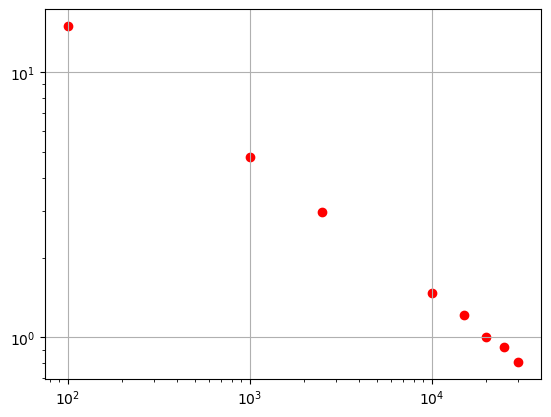

In [300]:
import matplotlib.pyplot as plt


plt.scatter(
    n_trajectories_list, std_list,
    color='red'
)
plt.xscale('log')
plt.yscale('log')

plt.grid(True)
plt.show()

С учётом размера номинала при симуляциях можно использовать 1000 траекторий. В этом случае уровень стандартного отклонения становится менее 0.1% от размера номинала.

**Пояснение по выборку `dt`**

В финансовых рынках обычно предполагается, что в году 252 торговых дня. По этой причине значение `dt = 1 / 252` часто используется на практике для дискретизации.